# Analyse de sensibilité

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.ModelePensionProbabiliste import ModelePensionProbabiliste
from retraites.EtudeImpact import EtudeImpact
import openturns as ot
import openturns.viewer as otv
import pylab as pl
import scipy as sp
import numpy as np

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

In [3]:
etudeImpact = EtudeImpact(simulateur)
analyse_etudeImpact = etudeImpact.calcule()

In [4]:
analyse_COR = simulateur.pilotageCOR()

## Définition du modèle probabiliste

In [5]:
def CalculeModeleProbabilisteEtudeImpact(
    simulateur, analyse_etudeImpact, analyse_COR, annee
):
    """
    Calcule un modèle probabiliste dans lequel les paramètres sont fixés. 
    Les bornes de la loi uniforme pour l'âge de départ en retraite 
    augmentent progressivement. 
    """
    S = analyse_etudeImpact.S[simulateur.scenario_central][annee]
    D = analyse_etudeImpact.Depenses[simulateur.scenario_central][annee]
    ageMin = analyse_COR.A[simulateur.scenario_central][simulateur.horizon]
    ageMax = 67.0
    modele = ModelePensionProbabiliste(
        simulateur,
        annee,
        S,
        D,
        bornesAgeConstant=False,
        ageMin=ageMin,
        ageMax=ageMax,
    )
    return modele

In [6]:
annee = 2070  # Année de calcul
modele = CalculeModeleProbabilisteEtudeImpact(
    simulateur, analyse_etudeImpact, analyse_COR, annee
)

Nous souhaitons probabiliser les variables suivantes :
* $A_s$ : l'âge moyen de départ à la retraite défini par l'utilisateur
* $F$ : coefficient d'élasticité de report de l'âge de départ (par défaut, $F = 0.5$)
* $\tau_c$ : le taux de chômage

Le solde financier $S_s$ est fixé à zéro et le niveau de dépense $D_s$ à 14% du PIB. Analysons dans ces conditions la sensibilité du niveau de pension $P_s$  à l'âge moyen de départ à la retraite $A_s$, au facteur d'élasticité $F$ et au taux de chômage $\tau_c$.

In [7]:
fonctionPension = modele.getFonction()

In [8]:
inputDistribution = modele.getInputDistribution()

## Analyse de sensibilité

In [9]:
size = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
inputDesign = sie.generate()

In [10]:
outputDesign = fonctionPension(inputDesign)

In [11]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(
    inputDesign, outputDesign, size
)

In [12]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

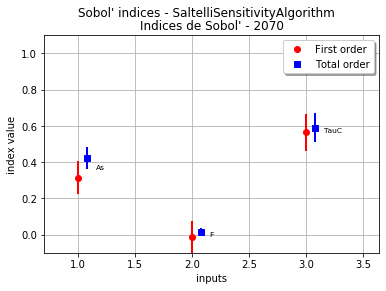

In [13]:
graph = sensitivityAnalysis.draw()
view = otv.View(graph)
pl.title("Indices de Sobol' - %d" % (annee));

On ne peut pas identifier d'interactions entre les variables puisque les indices totaux sont proches des indices du premier ordre. De plus, on observe que le coefficient d'élasticité n'est pas très influent en 2070 : celui-ci pourrait être remplacé par une constante. En revanche, l'âge de départ et le taux de chômage sont des variables qui influencent à un niveau égal la variabilité du niveau de pension en 2070. 

## Indices de Sobol' en fonction de l'année

In [14]:
def calculeIndicesSobol(annee, analyse_etudeImpact, analyse_COR, size=1000):
    """
    Calcule les indices de Sobol' pour une année donnée.
    
    Paramètres
    annee : un float, l'année
    S : le solde financier
    D : les dépenses de retraite (% PIB)
    sensitivityAnalysis : l'analyse de sensibilité
    
    """
    # Crée le modèle
    modele = CalculeModeleProbabilisteEtudeImpact(
        simulateur, analyse_etudeImpact, analyse_COR, annee
    )
    fonctionPension = modele.getFonction()
    inputDistribution = modele.getInputDistribution()
    # Calcule les indices de Sobol'
    computeSecondOrder = False
    sie = ot.SobolIndicesExperiment(
        inputDistribution, size, computeSecondOrder
    )
    inputDesign = sie.generate()
    outputDesign = fonctionPension(inputDesign)
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(
        inputDesign, outputDesign, size
    )
    return sensitivityAnalysis

In [15]:
table_annees = ot.Sample(range(2025, 2071, 5), 1)
nbAnnees = len(table_annees)
firstOrderIndices = ot.Sample(nbAnnees, 3)
firstOrderIndicesUpper = ot.Sample(nbAnnees, 3)
firstOrderIndicesLower = ot.Sample(nbAnnees, 3)
totalOrderIndices = ot.Sample(nbAnnees, 3)
totalOrderIndicesUpper = ot.Sample(nbAnnees, 3)
totalOrderIndicesLower = ot.Sample(nbAnnees, 3)
for i in range(nbAnnees):
    a = table_annees[i, 0]
    print(a)
    sensitivityAnalysis = calculeIndicesSobol(
        a, analyse_etudeImpact, analyse_COR
    )
    firstOrderIndices[i] = sensitivityAnalysis.getFirstOrderIndices()
    totalOrderIndices[i] = sensitivityAnalysis.getTotalOrderIndices()
    interval = sensitivityAnalysis.getFirstOrderIndicesInterval()
    firstOrderIndicesUpper[i] = interval.getUpperBound()
    firstOrderIndicesLower[i] = interval.getLowerBound()
    interval = sensitivityAnalysis.getTotalOrderIndicesInterval()
    totalOrderIndicesUpper[i] = interval.getUpperBound()
    totalOrderIndicesLower[i] = interval.getLowerBound()

2025.0
2030.0
2035.0
2040.0
2045.0
2050.0
2055.0
2060.0
2065.0
2070.0


In [16]:
alpha = sensitivityAnalysis.getConfidenceLevel()
alpha

0.95

In [17]:
def setGraphBoundingBox(graph, xmin=None, xmax=None, ymin=None, ymax=None):
    """
    Set the bounding box in a graph with keywords.
    
    Parameters
    xmin : the x minimum value
    xmax : the x maximum value
    ymin : the y minimum value
    ymax : the y maximum value
    """
    boundingBox = graph.getBoundingBox()
    lb = boundingBox.getLowerBound()
    ub = boundingBox.getUpperBound()
    if xmin is not None:
        lb[0] = xmin
    if ymin is not None:
        lb[1] = ymin
    if xmax is not None:
        ub[0] = xmax
    if ymax is not None:
        ub[1] = ymax
    boundingBox.setLowerBound(lb)
    boundingBox.setUpperBound(ub)
    graph.setBoundingBox(boundingBox)
    return graph

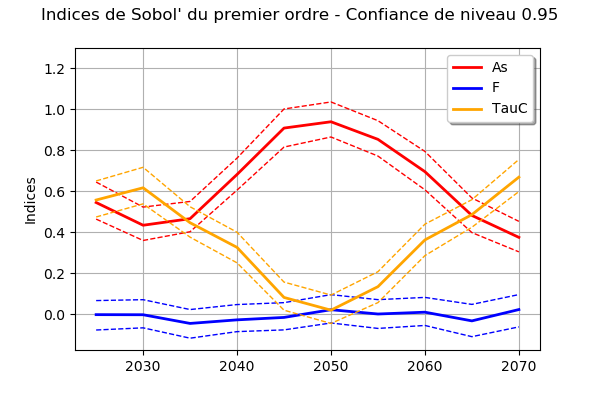

In [18]:
title = "Indices de Sobol' du premier ordre - Confiance de niveau %.2f" % (
    alpha
)
xTitle = ""
yTitle = "Indices"
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, firstOrderIndices[:, i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i])
    curve.setLineWidth(2)
    graph.add(curve)
    curve = ot.Curve(table_annees, firstOrderIndicesUpper[:, i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, firstOrderIndicesLower[:, i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax=1.3)
graph

Le graphique précédent représente la sensibilité du modèle aux trois variables probabilisées. Les lignes continues représentent les indices de sensibilité tandis que les lignes discontinues représentent l'intervalle de confiance de niveau 95%. 

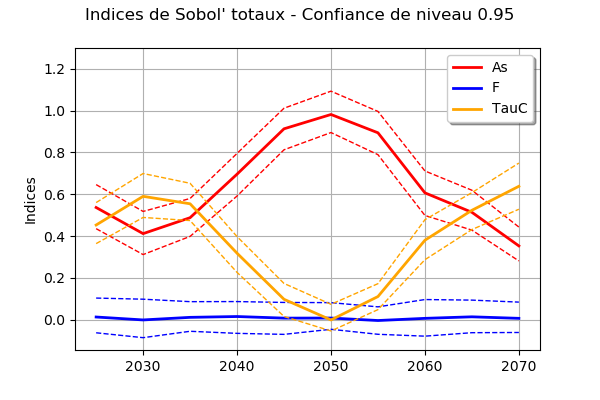

In [19]:
title = "Indices de Sobol' totaux - Confiance de niveau %.2f" % (alpha)
xTitle = ""
yTitle = "Indices"
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, totalOrderIndices[:, i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i])
    curve.setLineWidth(2)
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndicesUpper[:, i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndicesLower[:, i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax=1.3)
graph

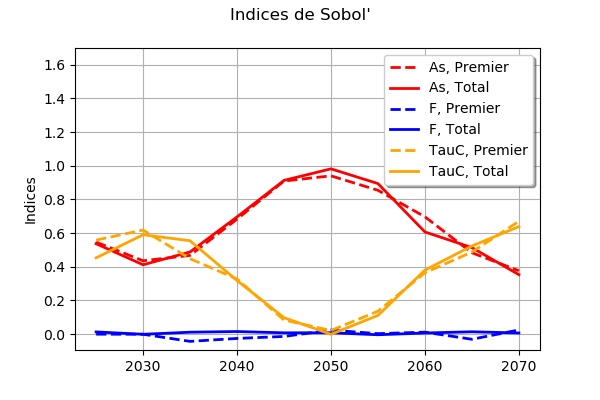

In [20]:
title = "Indices de Sobol'"
xTitle = ""
yTitle = "Indices"
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, firstOrderIndices[:, i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i] + ", Premier")
    curve.setLineWidth(2)
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndices[:, i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i] + ", Total")
    curve.setLineWidth(2)
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax=1.7)
graph

## Conclusion 

On observe que le facteur d'élasticité de report de l'âge de départ en retraite n'est pas un paramètre influent, et ce quelle que soit l'année considérée. Les indices du premier ordre sont proches des indices totaux, ce qui montre qu'il n'y a pas d'interactions entre les variables. 

Les deux variables influentes sont l'âge effectif moyen de départ en retraite et le taux de chômage. Jusqu'en 2040, les deux variables ont des effets comparables. Puis de 2040 à 2060, l'âge de départ en retraite possède plus d'influence sur la variabilité du niveau de pension par rapport aux salaires. À partir de 2050, l'influence du taux de chômage se met à augmenter au détriment de celle de l'âge de départ à la retraite. Entre 2065 et 2070, taux de chômage et âge de départ à la retraite sont aussi influents l'un que l'autre.